In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
if torch.cuda.is_available():
  imsize = 512
else:
  imsize = 256


loader = transforms.Compose([
            transforms.Resize((imsize,imsize)),
            transforms.ToTensor()
            ])


In [ ]:
def image_loader(image_name):
  image = Image.open(image_name)
  print(image.size)
  image = loader(image).unsqueeze(0)
  print(image.size())
  return image.to(device,torch.float)

In [ ]:
content_img = image_loader('/content/drive/My Drive/Colab Notebooks/Data/city_night.jpg')
style_img = image_loader('/content/drive/My Drive/Colab Notebooks/Data/starry night.jpg')

assert style_img.size() == content_img.size()



(960, 544)
torch.Size([1, 3, 512, 512])
(1600, 1264)
torch.Size([1, 3, 512, 512])


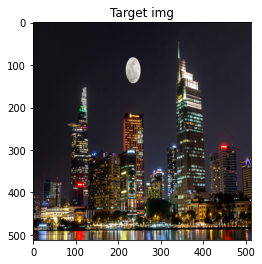

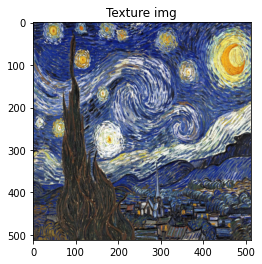

In [ ]:
unloader = transforms.ToPILImage()
plt.ion()
def imshow(tensor, title = None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
imshow(content_img, "Target img")
plt.figure()
imshow(style_img, "Texture img")
  

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self,target):
    super(ContentLoss,self).__init__()

    self.target = target.detach()
  def forward(self,input):
    self.loss = F.mse_loss(input,self.target)
    return input

In [ ]:
def gram_matrix(input):
  a,b,c,d = input.size()

  features = input.view(a * b, c * d)

  G = torch.mm(features,features.t())

  G = G.div(a*b*c*d)
  return G

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self,target_feature):
    super(StyleLoss,self).__init__()
    self.target = gram_matrix(target_feature).detach()
  
  def forward(self,input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G,self.target)
    return input

In [ ]:
cnn = models.vgg19(pretrained = True).features.to(device).eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
cnn_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_norm_std = torch.tensor([0.229, 0.224, 0.22]).to(device)

class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization,self).__init__()
    self.mean = torch.tensor(mean).view(-1,1,1)
    self.std = torch.tensor(std).view(-1,1,1)
  def forward(self,img):
    return (img - self.mean)/self.std



In [ ]:
# layers to compute the content and style losses at 
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn,normalization_mean, normalization_std,
                               style_img,content_img,
                               content_layers = content_layers_default,
                               style_layers = style_layers_default):
  
  normalization = Normalization(normalization_mean,normalization_std)
  model = nn.Sequential(normalization)
  content_losses = []
  style_losses = []
  i = 0
  for layer in cnn.children():
    if isinstance(layer,nn.Conv2d):
      i += 1
      name = "conv_{}".format(i)
    elif isinstance(layer,nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace = False)
    elif isinstance(layer,nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer,nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError("UNRECOGNIZED LAYER")
    model.add_module(name,layer)
    
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i),content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module('style_loss_{}'.format(i),style_loss)
      style_losses.append(style_loss)
  
  
  for i in range(len(model)-1,-1,-1):
    if isinstance(model[i],ContentLoss) or isinstance(model[i],StyleLoss):
      break

  model = model[:(i+1)]
  return model,style_losses,content_losses

    

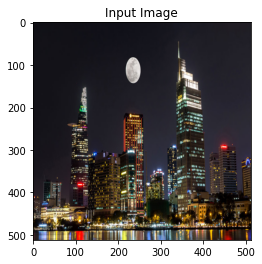

In [ ]:
input_img = content_img.clone()
plt.figure()
imshow(input_img,title = "Input Image")

In [ ]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img])
  return optimizer

In [ ]:
def run_style_transfer(cnn,normalization_mean, normalization_std, content_img,
                       style_img,input_img,num_steps = 300,style_weight = 10000000,
                       content_weight = 1):
  print("--- Building the Style Transfer Model ---")

  model, style_losses,content_losses = get_style_model_and_losses(cnn,
                                                        normalization_mean,
                                                        normalization_std,
                                                        style_img,content_img)
  

  input_img.requires_grad_(True)
  model.requires_grad_(False)

  optimizer = get_input_optimizer(input_img)

  print("Optimizing...")

  run = [0]


  while run[0]<= num_steps:

    def closure():
      with torch.no_grad():
        input_img.clamp_(0,1)
      
      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      
      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()
      
      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            style_score.item(), content_score.item()))
        print()
      return style_score + content_score

    optimizer.step(closure)
  
  with torch.no_grad():
    input_img.clamp_(0,1)
  
  return input_img





--- Building the Style Transfer Model ---
Optimizing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 10.384470 Content Loss: 26.906878

run [100]:
Style Loss : 8.721596 Content Loss: 25.013483

run [150]:
Style Loss : 7.135374 Content Loss: 23.640055

run [200]:
Style Loss : 5.556074 Content Loss: 22.764046

run [250]:
Style Loss : 4.268050 Content Loss: 22.123709

run [300]:
Style Loss : 3.329620 Content Loss: 21.557163



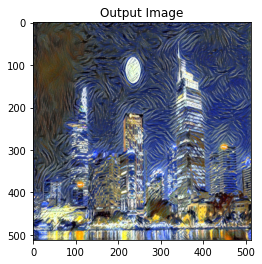

In [ ]:
output = run_style_transfer(cnn, cnn_norm_mean,
                            cnn_norm_std, content_img,
                            style_img, input_img)
plt.figure()
imshow(output,title = "Output Image")

plt.ioff()
plt.show()
